# Introduction to SageMaker TensorFlow - Object Detection

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

---

---
Welcome to [Amazon SageMaker Built-in Algorithms](https://sagemaker.readthedocs.io/en/stable/algorithms/index.html)! You can use SageMaker Built-in algorithms to solve many Machine Learning tasks through [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html). You can also use these algorithms through one-click in SageMaker Studio via [JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html).

In this demo notebook, we demonstrate how to use the TensorFlow Object Detection algorithm. Object Detection refers to predicting the objects in an image via bounding boxes.  We demonstrate two use cases of TensorFlow Object Detection models:

* How to use a model pre-trained on COCO '17 dataset to predict objects in an image. [COCO Labels](https://github.com/amikelive/coco-labels/blob/master/coco-labels-2014_2017.txt).
* How to fine-tune a pre-trained model to a custom dataset, and then run inference on the fine-tuned model.

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve Artifacts & Deploy an Endpoint](#3.1.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
    * [Download example images for inference](#3.2.-Download-example-images-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Display Model Predictions](#3.4.-Display-Model-Predictions)
    * [Clean up the endpoint](#3.5.-Clean-up-the-endpoint)
4. [Fine-tune the pre-trained model on a custom dataset](#4.-Fine-tune-the-pre-trained-model-on-a-custome-dataset)
    * [Retrieve Training artifacts](#4.1.-Retrieve-Training-artifacts)
    * [Set Training parameters](#4.2.-Set-Training-parameters)
    * [Train with Automatic Model Tuning (HPO)](#AMT)
    * [Start Training](#4.4.-Start-Training)
    * [Extract Training performance metrics](#4.5.-Extract-Training-performance-metrics)
    * [Deploy & run Inference on the fine-tuned model](#4.6.-Deploy-&-run-Inference-on-the-fine-tuned-model)
    * [Incrementally train the fine-tuned model](#4.7.-Incrementally-train-the-fine-tuned-model)

## 1. Set Up
***
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.
***

In [6]:
!pip install sagemaker ipywidgets --upgrade --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


---

To train and host on Amazon Sagemaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [48]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## 2. Select a pre-trained model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

In [49]:
infer_model_id, infer_model_version = "tensorflow-od1-ssd-resnet50-v1-fpn-640x640-coco17-tpu-8", "*"

***
[Optional] Select a different Sagemaker pre-trained model. Here, we download the model_manifest file from the Built-In Algorithms s3 bucket, filter-out all the Object Detection models and select a model for inference. Note that the models identified with the prefix tensorflow-od1- can be used to run inference or fine-tune on a custom dataset. Models identified with the prefix tensorflow-od- currently only support inference and can not be fine-tuned on a custom dataset.
***

In [50]:
import IPython
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.jumpstart.filters import And, Or

# Retrieves all TensorFlow Object Detection models.
filter_value = Or(
    And("task == od1", "framework == tensorflow"), And("task == od", "framework == tensorflow")
)
tensorflow_od_models = list_jumpstart_models(filter=filter_value)

model_id = "tensorflow-od1-ssd-resnet50-v1-fpn-640x640-coco17-tpu-8"
model_version = "*"

# display the model-ids in a dropdown, for the user to select a model.
dropdown = Dropdown(
    options=tensorflow_od_models,
    value=model_id,
    description="SageMaker Built-In TensorFlow Object Detection Models:",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(IPython.display.Markdown("## Select a SageMaker pre-trained model from the dropdown below"))
display(dropdown)

## Select a SageMaker pre-trained model from the dropdown below

Dropdown(description='SageMaker Built-In TensorFlow Object Detection Models:', index=48, layout=Layout(width='…

## 3. Run inference on the pre-trained model
***
Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a custom dataset. For this example, that means on an input image, predicting the [objects from one of the 80 classes of the COCO '17 dataset](https://github.com/amikelive/coco-labels/blob/master/coco-labels-2014_2017.txt).
***

### 3.1. Retrieve Artifacts & Deploy an Endpoint
***
We retrieve the deploy_image_uri, deploy_source_uri, and base_model_uri for the pre-trained model. To host the pre-trained base-model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This can take up to 15 minutes.
***

In [10]:
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

# model_version="*" fetches the latest version of the model.
#infer_model_id, infer_model_version = dropdown.value, "*"

endpoint_name = name_from_base(f"jumpstart-example-{infer_model_id}")

inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=infer_model_id,
    model_version=infer_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri.
deploy_source_uri = script_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, script_scope="inference"
)
# Retrieve the base model uri.
base_model_uri = model_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, model_scope="inference"
)
# Create the SageMaker model instance. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)
# deploy the Model.
base_model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    endpoint_name=endpoint_name,
)

------------!

### 3.2. Download example images for inference
***
We download example images from a public S3 bucket.
***

In [11]:
aws_region

'us-east-1'

In [12]:
s3_bucket = f"jumpstart-cache-prod-{aws_region}"
key_prefix = "inference-notebook-assets"
Naxos_Taverna = "Naxos_Taverna.jpg"


boto3.client("s3").download_file(s3_bucket, f"{key_prefix}/{Naxos_Taverna}", Naxos_Taverna)

### 3.3. Query endpoint and parse response
***
Input to the endpoint is a single image in binary format. Response of the endpoint is a set of bounding boxes as well as class names and scores for the bounding boxes. JumpStart allows the flexibility in the number of bounding boxes returned. Below, we show to predict two bounding boxes per image by appending `;n_predictions=5` to `Accept`. To predict xx boxes, one can change it to `;n_predictions=xx` or to get all the predicted boxes, one can remove `;n_predictions=5`.
***

In [38]:
import json


def query(model_predictor, image_file_name):

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose;n_predictions=1",
        },
    )
    return query_response


def parse_response(query_response):
    model_predictions = json.loads(query_response)
    normalized_boxes, classes, scores, labels = (
        model_predictions["normalized_boxes"],
        model_predictions["classes"],
        model_predictions["scores"],
        model_predictions["labels"],
    )
    # Substitute the classes index with the classes name
    #class_names = [labels[int(idx)] for idx in classes]
    return normalized_boxes, classes, scores

In [14]:
query_response = query(base_model_predictor, Naxos_Taverna)

normalized_boxes, classes_names, confidences = parse_response(query_response)

In [79]:
type(query_response)

bytes

### 3.4. Display Model Predictions
***
Next, we display the bounding boxes overlaid on the original image.
***

In [94]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageColor
import numpy as np


def display_predictions(img_jpg, normalized_boxes, classes_names, confidences):
    print(normalized_boxes)
    colors = list(ImageColor.colormap.values())
    image_np = np.array(Image.open(img_jpg))
    plt.figure(figsize=(20, 20))
    ax = plt.axes()
    ax.imshow(image_np)

    for idx in range(len(normalized_boxes)):
        left, bot, right, top = normalized_boxes[idx]
        x, w = [val * image_np.shape[1] for val in [left, right - left]] #image_np.shape[1] = image width 
        print("x:",x) # x min
        print("w",w) # xmax
        y, h = [val * image_np.shape[0] for val in [bot, top - bot]] #image_np.shape[1] = image width  is height
        print("y:",y) #ymax
        print("h:",h) #height
        color = colors[hash(classes_names[idx]) % len(colors)]
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(
            x,
            y,
            "{} {:.0f}%".format(classes_names[idx], confidences[idx] * 100),
            bbox=dict(facecolor="white", alpha=0.5),
        )

In [40]:
normalized_boxes

[[0.294811666, 0.638600945, 0.397601068, 0.920432]]

[[0.294811666, 0.638600945, 0.397601068, 0.920432]]


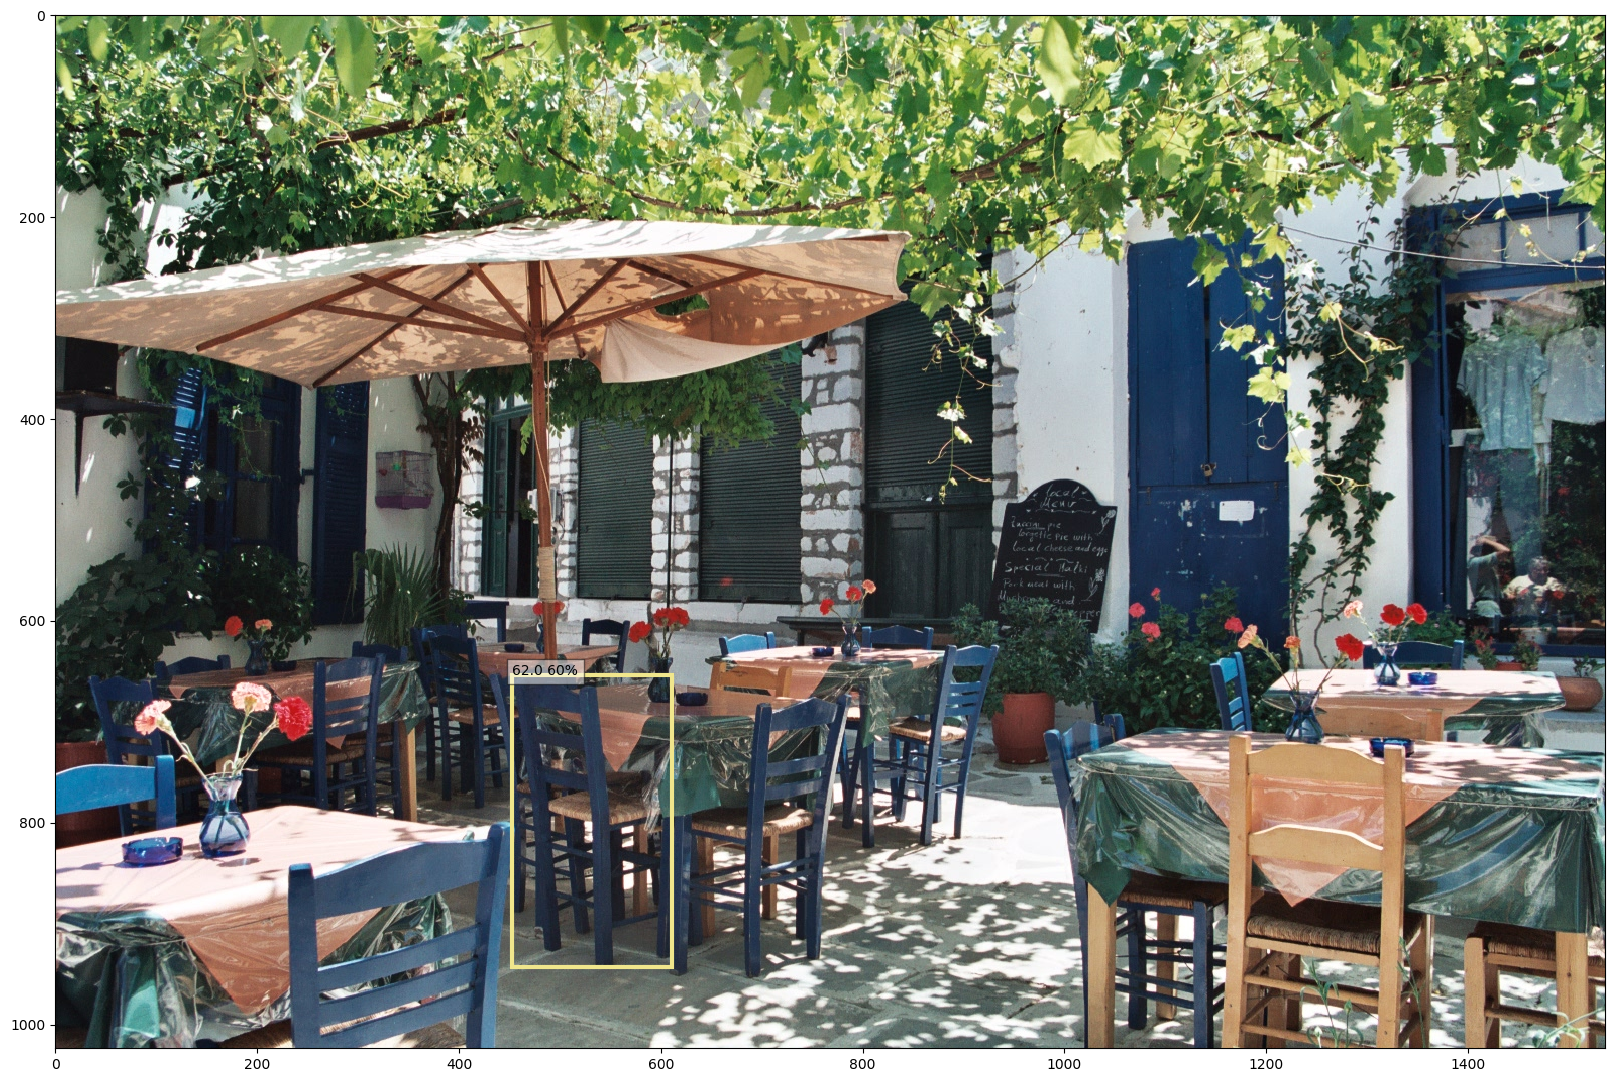

In [41]:
%matplotlib inline
display_predictions(Naxos_Taverna, normalized_boxes, classes_names, confidences)

### 3.5. Clean up the endpoint

In [42]:
# Delete the SageMaker endpoint and the attached resources
base_model_predictor.delete_model()
base_model_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: jumpstart-example-tensorflow-od1-ssd-re-2023-06-20-10-17-53-965


Exception: One or more models cannot be deleted, please retry. 
Failed models: jumpstart-example-tensorflow-od1-ssd-re-2023-06-20-10-17-53-965

## 4. Fine-tune the pre-trained model on a custom dataset
***

Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be finetuned to a custom dataset with any number of classes.

Transfer learning algorithm removes the object detection head of the pre-trained model and attaches a new randomly initialized head with number of classes same as the custom dataset. The fine-tuning step fine-tunes the last layer parameters while keeping the parameters of the rest of the model frozen, and returns the fine-tuned model. The objective during finetuning is to minimize box prediction error on the input data.

- **Input** – A directory with sub-directory images and a file annotations.json.

- **Output** – A fine-tuned model that can be deployed for inference or can be further trained using incremental training. A file mapping class indexes to class labels is saved along with the models.

The input directory should look like below if the training data contains two images. The names of .png files can be anything.

The s3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

    input_directory
        |--images
            |--abc.png
            |--def.png
        |--annotations.json

The annotations.json file should have information for bounding_boxes and their class labels. It should have a dictionary with keys "images" and "annotations". Value for the "images" key should be a list of entries, one for each image of the form {"file_name": image_name, "height": height, "width": width, "id": image_id}. Value of the 'annotations' key should be a list of entries, one for each bounding box of the form {"image_id": image_id, "bbox": [xmin, ymin, xmax, ymax], "category_id": bbox_label}.

We provide pennfudanped dataset as a default dataset for fine-tuning the model. PennFudanPed comprises images of pedestrians. The dataset has been downloaded from here.

Citation: @ONLINE {pennfudanped, author = "Liming Wang1, Jianbo Shi2, Gang Song2, and I-fan Shen1", title = "Penn-Fudan Database for Pedestrian Detection and Segmentation", year = "2007", url = "https://www.cis.upenn.edu/~jshi/ped_html/" }

***

### 4.1. Retrieve Training artifacts
***
Here, for the selected model, we retrieve the training docker container, the training algorithm source, the pre-trained base model, and a python dictionary of the training hyper-parameters that the algorithm accepts with their default values. Note that the model_version="*" fetches the latest model. Also, we do need to specify the training_instance_type to fetch train_image_uri.
***

In [51]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters

model_id, model_version = dropdown.value, "*"
training_instance_type = "ml.p2.8xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=model_id,
    model_version=model_version,
    image_scope="training",
    instance_type=training_instance_type,
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="training"
)

# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="training"
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


### 4.2. Set Training parameters
***
Now that we are done with all the setup that is needed, we are ready to fine-tune our Object Detection model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. 

The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training. We defined the training instance type above to fetch the correct train_image_uri. 

The second set of parameters are algorithm specific training hyper-parameters.
***

In [44]:
# Sample training data is available in this bucket
training_data_bucket = "plant-disease-detection-datasets"
training_data_prefix = "input_directory/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = "plant-disease-detection-datasets"
output_prefix = "output_directory"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [45]:
import boto3
from io import BytesIO
from PIL import Image

s3 = boto3.client('s3')
bucket_name = 'plant-disease-detection-datasets'
training_data_prefix = 'input_directory/images/'

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=training_data_prefix)

for obj in response['Contents']:
    image_key = obj['Key']
    if image_key.endswith('/'):
        continue

    response = s3.get_object(Bucket=bucket_name, Key=image_key)
    image_data = response['Body'].read()

    image = Image.open(BytesIO(image_data))
    width, height = image.size

    if width == 0 or height == 0:
        print(f"Image {image_key}")

In [34]:
! aws s3 ls s3://plant-disease-detection-datasets/input_directory/images/ | wc -l

244


***
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.
***

In [52]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(model_id=model_id, model_version=model_version)

# [Optional] Override default hyperparameters with custom values
hyperparameters["epochs"] = "5"
# reduce batch size from 16 to 4 
hyperparameters["batch_size"] = "4"
print(hyperparameters)

{'batch_size': '4', 'reinitialize_top_layer': 'Auto', 'train_only_top_layer': 'True', 'optimizer': 'adam', 'learning_rate': '0.002', 'beta_1': '0.9', 'beta_2': '0.999', 'momentum': '0.9', 'epsilon': '1e-07', 'rho': '0.95', 'initial_accumulator_value': '0.1', 'early_stopping': 'True', 'early_stopping_patience': '5', 'early_stopping_min_delta': '0.0', 'epochs': '5'}


### 4.3. Train with Automatic Model Tuning ([HPO](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)) <a id='AMT'></a>
***
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) object to interact with Amazon SageMaker hyperparameter tuning APIs.
***

In [53]:
from sagemaker.tuner import ContinuousParameter

# Use AMT for tuning and selecting the best model
use_amt = False

# Define objective metric per framework, based on which the best model will be selected.
amt_metric_definitions = {
    "metrics": [{"Name": "validation:localization_loss", "Regex": "Val_localization=([0-9\\.]+)"}],
    "type": "Minimize",
}

# You can select from the hyperparameters supported by the model, and configure ranges of values to be searched for training the optimal model.(https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html)
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.000001, 0.5, scaling_type="Logarithmic")
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 3
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2

### 4.4. Start Training
***
We start by creating the estimator object with all the required assets and then launch the training job. This can take up to 30 minutes.
***

In [57]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{model_id}-transfer-learning")

training_metric_definitions = [
    {"Name": "val_localization_loss", "Regex": "Val_localization=([0-9\\.]+)"},
    {"Name": "val_classification_loss", "Regex": "Val_classification=([0-9\\.]+)"},
    {"Name": "train_loss", "Regex": "loss=([0-9\\.]+)."},
]

# Create SageMaker Estimator instance
od_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
    metric_definitions=training_metric_definitions,
)

#hp_tuner = HyperparameterTuner(
#    od_estimator,
#    amt_metric_definitions["metrics"][0]["Name"],
#    hyperparameter_ranges,
#    amt_metric_definitions["metrics"],
#    max_jobs=max_jobs,
#    max_parallel_jobs=max_parallel_jobs,
#   objective_type=amt_metric_definitions["type"],
#   base_tuning_job_name=training_job_name,
#)
# Launch a SageMaker Tuning job to search for the best hyperparameters
#hp_tuner.fit({"training": training_dataset_s3_path})

# Launch a SageMaker Training job by passing s3 path of the training data
od_estimator.fit({"training": training_dataset_s3_path}, logs=True)


INFO:sagemaker:Creating training-job with name: jumpstart-example-tensorflow-od1-ssd-re-2023-06-21-08-40-03-529


2023-06-21 08:40:03 Starting - Starting the training job.........
2023-06-21 08:41:11 Starting - Preparing the instances for training.........
2023-06-21 08:43:01 Downloading - Downloading input data...
2023-06-21 08:43:31 Training - Downloading the training image.....................
2023-06-21 08:46:58 Training - Training image download completed. Training in progress....2023-06-21 08:47:25.701308: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-06-21 08:47:25.701486: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-06-21 08:47:25.748855: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-06-21 08:47:28,232 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2023-06-21 08:47:28,318 sagemake

### 4.5. Extract Training performance metrics
***
Performance metrics such as training loss and validation localization/classification loss can be accessed through cloudwatch while the training. Code below provides the link to the cloudwatch log where these metrics can be found. 

Note that default resolution in Amazon Cloudwatch is one minute i.e. it averages the metrics logged within a single minute interval. Amazon CloudWatch also supports [high-resolution custom metrics](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/publishingMetrics.html), and its finest resolution is 1 second. However, the finer the resolution, the shorter the lifespan of the CloudWatch metrics. For the 1-second frequency resolution, the CloudWatch metrics are available for 3 hours. For more information about the resolution and the lifespan of the CloudWatch metrics, see [GetMetricStatistics](https://docs.aws.amazon.com/AmazonCloudWatch/latest/APIReference/API_GetMetricStatistics.html) in the Amazon CloudWatch API Reference.
***

In [58]:
if use_amt:
    training_job_name = hp_tuner.best_training_job()
else:
    training_job_name = od_estimator.latest_training_job.job_name

In [59]:
training_job_name

'jumpstart-example-tensorflow-od1-ssd-re-2023-06-21-08-40-03-529'

In [60]:
import sagemaker
from IPython.core.display import Markdown

sagemaker_session = sagemaker.Session()

link = (
    "https://console.aws.amazon.com/cloudwatch/home?region="
    + sagemaker_session.boto_region_name
    + "#metricsV2:query=%7B/aws/sagemaker/TrainingJobs,TrainingJobName%7D%20"
    + training_job_name
)
display(Markdown("CloudWatch metrics: [link](" + link + ")"))

CloudWatch metrics: [link](https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:query=%7B/aws/sagemaker/TrainingJobs,TrainingJobName%7D%20jumpstart-example-tensorflow-od1-ssd-re-2023-06-21-08-40-03-529)

***
Alternatively, we can also fetch these metrics and analyze them within the notebook.
***

In [61]:
from sagemaker import TrainingJobAnalytics

df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()

df.head(10)

timestamp              metric_name  value
0        0.0    val_localization_loss  3.658
1      300.0    val_localization_loss  4.056
2      540.0    val_localization_loss  3.809
3      780.0    val_localization_loss  4.066
4     1080.0    val_localization_loss  4.104
5        0.0  val_classification_loss  6.739
6      300.0  val_classification_loss  5.773
7      540.0  val_classification_loss  5.513
8      780.0  val_classification_loss  5.289
9     1080.0  val_classification_loss  5.269

***
We can filter out different metrics by names as well.
***

In [62]:
metric_names = [metric["Name"] for metric in training_metric_definitions]

metrics_df = {
    metric_name: df.query(f"metric_name == '{metric_name}'") for metric_name in metric_names
}

metrics_df["val_localization_loss"]

timestamp            metric_name  value
0        0.0  val_localization_loss  3.658
1      300.0  val_localization_loss  4.056
2      540.0  val_localization_loss  3.809
3      780.0  val_localization_loss  4.066
4     1080.0  val_localization_loss  4.104

## 4.6. Deploy & run Inference on the fine-tuned model
***
A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the class label of an image. We follow the same steps as in the [Section 3 - Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model). We start by retrieving the artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.
***

In [63]:
inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

#endpoint_name = name_from_base(f"jumpstart-example-FT-{model_id}-")
endpoint_name = "endpoint-with-no-hpo-apple"
# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = (hp_tuner if use_amt else od_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
    container_log_level=10
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py39.
INFO:sagemaker:Repacking model artifact (s3://plant-disease-detection-datasets/output_directory/output/jumpstart-example-tensorflow-od1-ssd-re-2023-06-21-08-40-03-529/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/tensorflow/inference/od1/v1.0.1/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-334842727856/sagemaker-jumpstart-2023-06-21-09-19-10-127/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-06-21-09-19-10-127
INFO:sagemaker:Creating endpoint-config with name endpoint-with-no-hpo-apple
INFO:sagemaker:Creating endpoint with name endpoint-with-no-hpo-apple


-------------!

---
Next, we download example images of pedestrian from the S3 bucket for inference.

---

In [81]:
s3_bucket = "plant-disease-detection-datasets"
key_prefix = "test"

image_file_name = "00.jpg"

boto3.client("s3").download_file(
    s3_bucket,
    f"{key_prefix}/{image_file_name}",
    image_file_name,
)

---
Next, we query the finetuned model, parse the response and display the predictions. Functions for these are implemented in sections [3.3. Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response) and [3.4. Display Model Predictions](#3.4.-Display-Model-Predictions).

---

[[0.147515565, 0.0285329521, 0.9276191, 0.825872302]]
x: 70.8074712
w 374.4496968
y: 10.271862756
h: 287.042165964


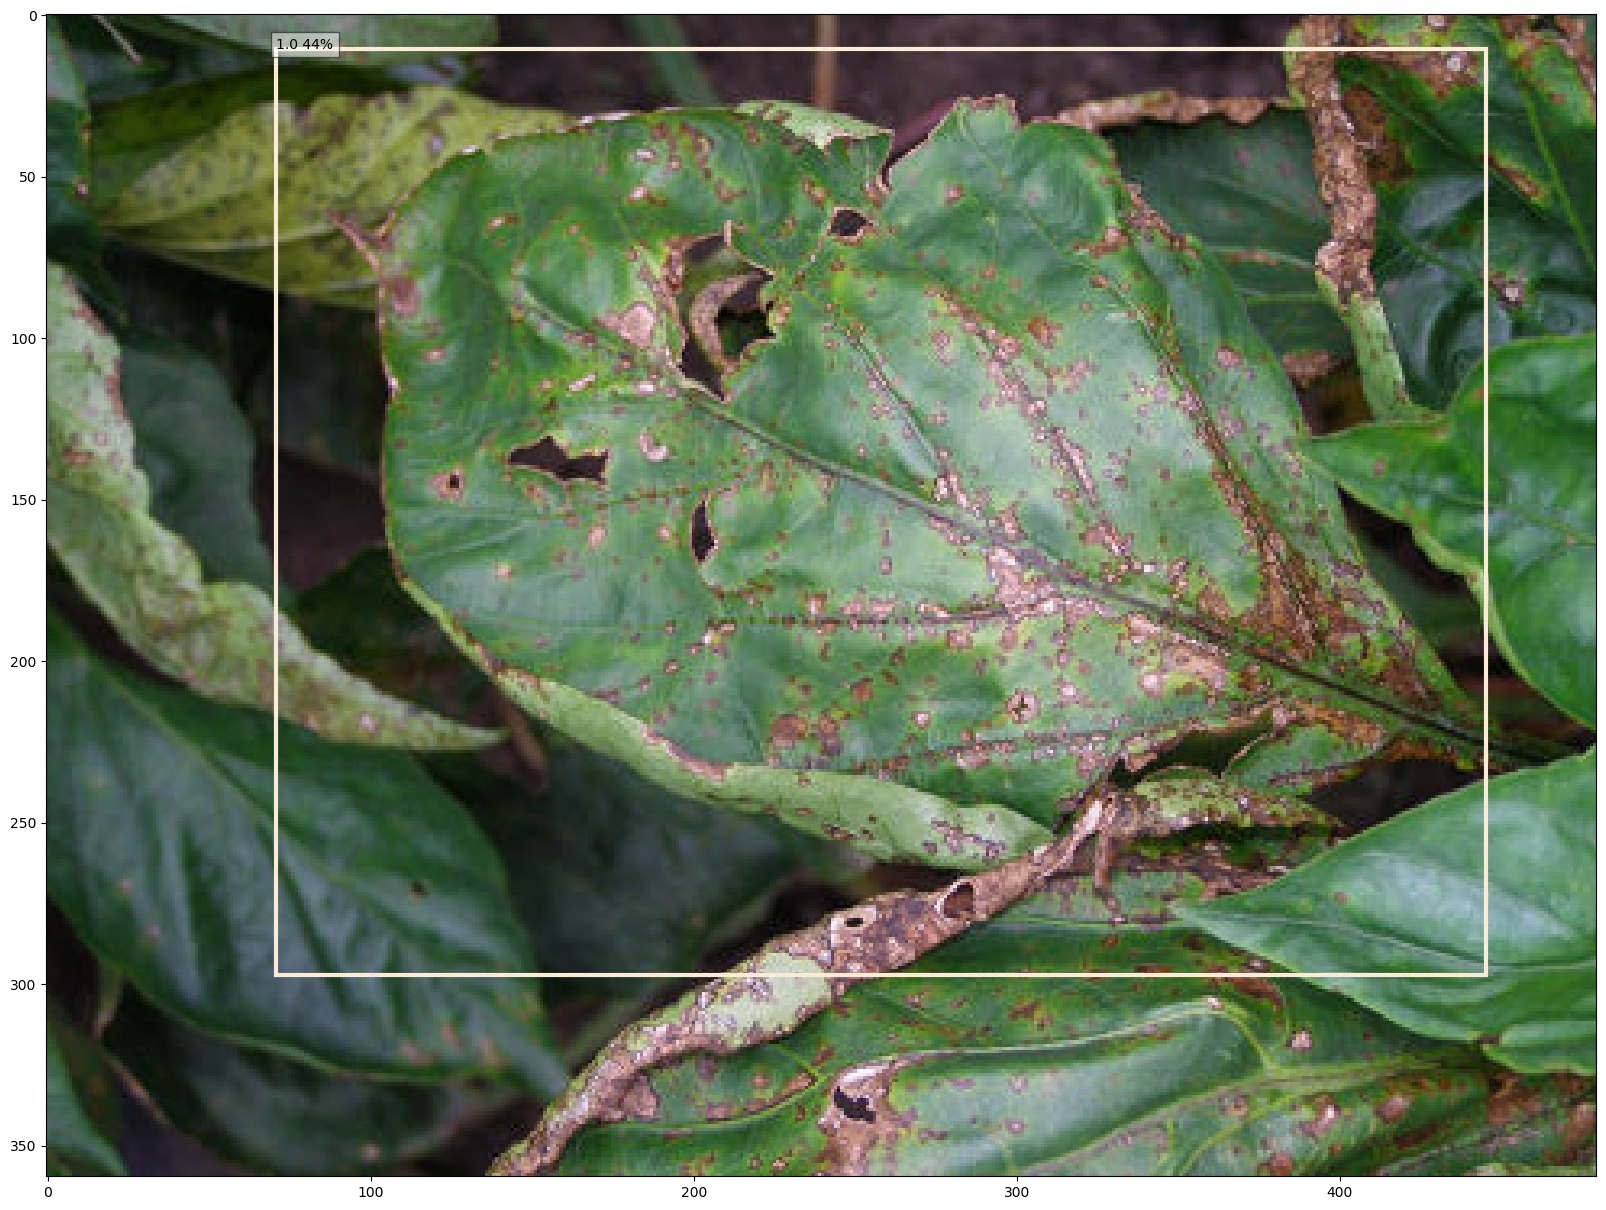

In [95]:
query_response = query(finetuned_predictor, image_file_name)

normalized_boxes, classes_names, confidences = parse_response(query_response)
%matplotlib inline
display_predictions(image_file_name, normalized_boxes, classes_names, confidences)

---
### Consolidate different predictions and leave the highest confidence bounding box and class 
---

In [ ]:
normalized_boxes

In [ ]:
bbox = np.array(normalized_boxes)
bbox

In [ ]:
scores = np.array(confidences) 

In [ ]:
def non_max_suppression(bboxes, scores, cids):
        x1 = bboxes[:, 0]
        y1 = bboxes[:, 1]
        x2 = bboxes[:, 2]
        y2 = bboxes[:, 3]
        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.flatten().argsort()[::-1]
        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])
            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w * h
            iou = inter / (areas[i] + areas[order[1:]] - inter)
            inds = np.where(iou <= 0.1)[0]
            order = order[inds + 1]
        bboxes = bboxes[keep]
        scores = scores[keep]
        cids = cids[keep]
        return bboxes, scores, cids

In [ ]:
classes_names = np.array(classes_names)
classes_names

In [ ]:
bbox,scores,classes_names= non_max_suppression(bbox, scores, classes_names)

In [ ]:
bbox.tolist()

In [82]:
%matplotlib inline
display_predictions(image_file_name, bbox.tolist(), classes_names.tolist(), scores.tolist())

NameError: name 'bbox' is not defined

---
Next, we clean up the deployed endpoint.

---

In [ ]:
# Delete the SageMaker endpoint and the attached resources
#finetuned_predictor.delete_model()
#finetuned_predictor.delete_endpoint()

## 4.7. Incrementally train the fine-tuned model

***
Incremental training allows you to train a new model using an expanded dataset that contains an underlying pattern that was not accounted for in the previous training and which resulted in poor model performance. You can use the artifacts from an existing model and use an expanded dataset to train a new model. Incremental training saves both time and resources as you don’t need to retrain a model from scratch.

One may use any dataset (old or new) as long as the dataset format remain the same (set of classes). Incremental training step is similar to the finetuning step discussed above with the following difference: In fine-tuning above, we start with a pre-trained model whereas in incremental training, we start with an existing fine-tuned model.
***

In [ ]:
# Identify the previously trained model path based on the output location where artifacts are stored previously and the training job name.

if use_amt:  # If using amt, select the model for the best training job.
    sage_client = boto3.Session().client("sagemaker")
    tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=hp_tuner._current_job_name
    )
    last_training_job_name = tuning_job_result["BestTrainingJob"]["TrainingJobName"]
else:
    last_training_job_name = od_estimator._current_job_name

last_trained_model_path = f"{s3_output_location}/{last_training_job_name}/output/model.tar.gz"

In [ ]:
incremental_train_output_prefix = "jumpstart-example-ic-incremental-training"

incremental_s3_output_location = f"s3://{output_bucket}/{incremental_train_output_prefix}/output"

incremental_training_job_name = name_from_base(f"jumpstart-example-{model_id}-incremental-training")

incremental_train_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=last_trained_model_path,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=incremental_s3_output_location,
    base_job_name=incremental_training_job_name,
    metric_definitions=training_metric_definitions,
)

incremental_train_estimator.fit({"training": training_dataset_s3_path}, logs=True)

Once trained, we can use the same steps as in [Deploy & run Inference on the fine-tuned model](#4.6.-Deploy-&-run-Inference-on-the-fine-tuned-model) to deploy the model.

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|object_detection_tensorflow|Amazon_Tensorflow_Object_Detection.ipynb)
